In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import json
import re
import copy

from tqdm.auto import tqdm
tqdm.pandas()

import seaborn as sns
sns.set_theme()

In [44]:
from utils import mappings, labeled_entities, helpers

In [45]:
pd.set_option('max_colwidth', 100)
pd.set_option('max_columns', 30)

## 1. Loading Pre-processed USDA Data for Food labels

For building this dataset, I have used [FoodData USDA (Version April 2020)](https://fdc.nal.usda.gov/download-datasets.html) as the base. This dataset contains different food mentions of different types. In order to infer the entity types of each of these food mentions, I have used [Google Knowledge Graph API](https://developers.google.com/knowledge-graph).
The entries that you see in the `food_processing`dataset below, are the results of Google Knowledge Graph API (`name`, `description`, `types`, and `id`). The `query` column contains the items that have been queried (from FoodData USPTO).

I still haven't included the codes for building this dataset

(*TO-DO: Add the codes for preparing this dataset!*)

In [46]:
foods_processing = pd.read_csv('./data/foods_list_usda.txt')
foods_processing['types'] = foods_processing.types.fillna('[]').apply(lambda x: json.loads(x.replace("'", '"')))

print('Number of rows: {:,}'.format(foods_processing.shape[0]))
foods_processing.head(2)

Number of rows: 44,086


,query,name,description,types,id,status,word_count
0,Hsyalm,NaN,NaN,[],NaN,succeed,one word
1,Kale,Wild cabbage,Plants,[Thing],kg:/m/04ylr2,succeed,one word


In [47]:
foods_processing = foods_processing.dropna(subset=['name'])
print('Number of rows: {:,}'.format(foods_processing.shape[0]))

Number of rows: 16,166


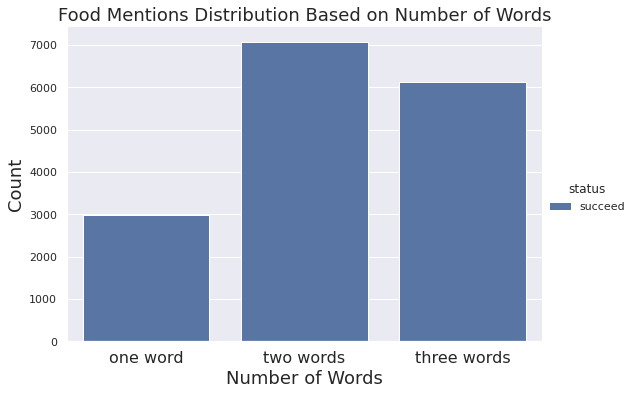

In [48]:
g = sns.catplot(x="word_count", hue="status", data=foods_processing, 
                kind="count", height=5, aspect=1.5);

g.ax.set_title('Food Mentions Distribution Based on Number of Words', fontsize=18);
g.set_xticklabels(fontsize=16, );
g.set_xlabels(fontsize=18, label='Number of Words');
g.set_ylabels(fontsize=18, label='Count');

# 2. Entity Extraction From FoodData USDA Preprocessed

## 2.1. Extracting Product Entities

In [49]:
products_mask = foods_processing['types'].apply(lambda x: bool(set(x if x is not None else [])\
                                                            .intersection(['Product', 'ProductModel'])))
products = foods_processing[products_mask]
print(products.shape)

(574, 7)


In [50]:
product_entities = products.copy()
product_entities['word'] = products['name']
product_entities['entity'] = 'product'

## 2.2. Extracting Other Remaining Entities

In [51]:
unrelated_mask = foods_processing.types.apply(lambda x: bool(set(x if x is not None else [])\
                                                           .intersection(['Product', 'ProductModel', 'Place'])))
food_entities = foods_processing[~unrelated_mask]
print(food_entities.shape)

(15318, 7)


In [52]:
def convert_to_food_entities(x):
    mapping = mappings.description_to_entityType.get(x['description'], {})
    return pd.Series([x[mapping.get('column', 'query')], mapping.get('type', 'others')])

# Building processed food entities list
food_entities_processed = pd.concat([
    pd.concat([
        food_entities, 
        food_entities.apply(lambda x: convert_to_food_entities(x), axis=1).rename(columns={0:'word', 1:'entity'})
    ], axis=1),
    product_entities
], axis=0, ignore_index=True)

## 2.3. Adding Additional Entities Manually

In [53]:
food_entities_mapping = pd.concat([
    food_entities_processed[food_entities_processed.entity!='others'][['word', 'entity']],
    pd.DataFrame(labeled_entities.additional_samples)
]).drop_duplicates().reset_index(drop=True)

In [54]:
food_entities_mapping.to_csv('./data/foods_entities.csv', index=False, encoding='utf-8')

# 3. Preparing Training Data Using Template

## 3.1. Labeled Training Data

In [56]:
labeled_samples = []
with open('../data/food/food_ner_samples_labeled_v10.jsonl', encoding='utf-8') as file:
    for line in file.readlines():
        labeled_samples.append(json.loads(line))

## 3.2. Loading Food Entities Examples

In [57]:
food_entities_mapping = pd.read_csv('./data/foods_entities.csv')
print(food_entities_mapping.shape)

(3072, 2)


In [58]:
final_mapping = {
     'ingredient': 'INGREDIENT',
     'food': 'FOOD',
     'product': 'PRODUCT',
     'organization': 'ORG',
     'beverage': 'DRINK',
     'flavor': 'FLAVOR/SMELL',
     'persona': 'PERSONA',
     'meal': 'OCCASION',
     'occasionConsumption': 'OCCASION',
     'occasionTime': 'OCCASION'
}

In [59]:
food_entities_mapping['entity'] = food_entities_mapping.entity.map(final_mapping)

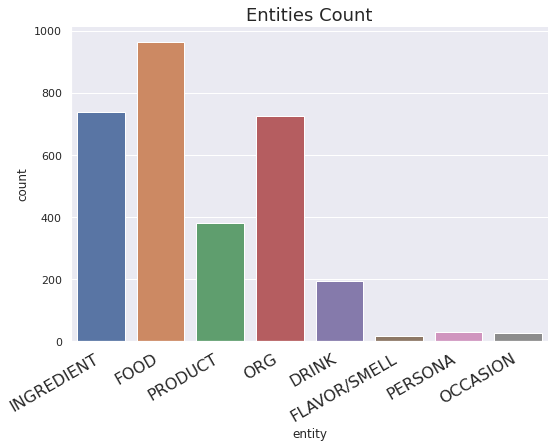

In [60]:
g = sns.catplot(x="entity", data=food_entities_mapping, 
                kind="count", height=5, aspect=1.5);
g.ax.set_title('Entities Count', fontsize=18);
g.set_xticklabels(rotation=30, ha='right', fontsize=16);

In [61]:
food_entities_mapping = food_entities_mapping.groupby('entity')['word'].apply(set).apply(tuple).to_dict()

## 3.3. Creating Additional Synthetic Data Using FoodData USDA Data

In [70]:
random.shuffle(labeled_samples)

training_samples = []

for elm in tqdm(labeled_samples):
    elm_template_text = elm['text']
    elm_template_entities = []
    shift_idx = 0
    special_entities = dict()
    for el in sorted(elm['labels'], key=lambda x: x[0]):
        # Adding to the special entities if not found in the `food_mapping` entities
        if el[2] not in final_mapping.values():
            values = special_entities.get(el[2], tuple())
            special_entities[el[2]] = values + (elm_template_text[el[0]-shift_idx:el[1]-shift_idx],)
        
        elm_template_text = elm_template_text[:el[0]-shift_idx]+ '{}' + elm_template_text[el[1]-shift_idx:]
        elm_template_entities.append(el[2])
        shift_idx += el[1] - el[0] - 2
    elm_template = dict(text=elm_template_text, entities=elm_template_entities)

    for i in range(40):
        if i==0:
            training_samples.append((elm['text'], dict(entities=tuple(elm['labels']))))
            continue
        sentence = elm_template['text']
        # Copying the mapping
        mapping = copy.deepcopy(food_entities_mapping)
        mapping.update(special_entities)
        # For each entity in template replace them with random entity from mapping
        entities = []
        for entity in elm_template['entities']:
            # If the entity is complete (with spans), add it directly to the entities list
            if isinstance(entity, tuple):
                entities.append(entity)
                continue
            # Take a random entity
            idx = np.random.randint(len(mapping[entity]))
            text = mapping[entity][idx]
            # Remove selected entity from the mapping
            mapping[entity] = helpers.remove_from_list(mapping[entity], idx)
            # Putting the selected entity into the sentence template
            text = text.lower()
            # Replacing "{}" with the text
            span = list(re.finditer('(\{\})', sentence))[0].span()
            sentence = sentence[:span[0]] + text + sentence[span[1]:]
            # Calculating new span after replacing with the text
            span = (span[0], span[0]+len(text))
            # Adding spans and entity type into list of entities
            entities.append((span[0], span[1], entity))
        # Adding the labeled data into the final list
        training_samples.append((sentence, dict(entities=entities)))

# 4. Train-test split

## 4.1. Splitting & Shuffling

In [71]:
# train-test split
train_ratio = 0.6
n_samples = len(training_samples)

We will first split the train-test samples and then shuffle, in order to prevent leaking training samples to the test set

In [72]:
training_set = training_samples[:int(0.4*n_samples)]
random.shuffle(training_set)

test_set = training_samples[int(0.4*n_samples):]
random.shuffle(test_set)

## 4.2. Saving Train-Test Datasets Into Appropriate Files

In [73]:
# Write to the disk
with open('./data/food_ner_dataset_training.jsonl', 'w', encoding='utf-8') as file:
    for line in tqdm(training_set):
        file.write(json.dumps(line)+'\n')

In [74]:
# Write to the disk
with open('./data/food_ner_dataset_test.jsonl', 'w', encoding='utf-8') as file:
    for line in tqdm(test_set):
        file.write(json.dumps(line)+'\n')